# Build neighbourhood VDJ feature space

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
import scanpy as sc
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import seaborn as sb
import dandelion as ddl

In [2]:
#### need to add this line to restore plotting function of scanpy in the presence of palantir
%matplotlib inline

In [3]:
# set working directory
%cd /lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/

/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript


In [4]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/VDJ_collab/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

In [5]:
sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]
sb.set_palette('colorblind')

# Load data

In [6]:
# downloaded from https://www.tissueimmunecellatlas.org/
adata = sc.read('/nfs/team205/cc36/2021_mnt_backup/mnt/Science_revision/write/adata_TILC_TCR_onlyseq.h5ad')

In [8]:
sc.pl.umap(adata, color=['organ_code','chain_pairing','manual_annot_v6','CD4','CD8A','CD8B',
                        'n_genes','n_counts'],legend_loc = 'on data',legend_fontsize=6)

# Filter cells

### subset cells with paired TCRab

In [9]:
# remove T_CD4/CD8 as low quality cluster
ct_order = ['MAIT',
            'Tem/emra_CD8','Tnaive/CM_CD8','Trm/em_CD8','Trm_gut_CD8',
            'Teffector/EM_CD4','Tfh','Tnaive/CM_CD4','Tnaive/CM_CD4_activated','Tregs','Trm_Th1/Th17']

In [10]:
bdata = adata[adata.obs['manual_annot_v6'].isin(ct_order)]

In [11]:
bdata = bdata[bdata.obs['chain_pairing'].isin(['single pair','extra VJ','extra VDJ','two full chains'])]

In [12]:
bdata.obs['annot_high'] = bdata.obs['manual_annot_v6'].astype('str')
bdata.obs.loc[bdata.obs['manual_annot_v6'].isin(['Tem/emra_CD8','Tnaive/CM_CD8','Trm/em_CD8','Trm_gut_CD8']),'annot_high'] = 'CD8+T'
bdata.obs.loc[bdata.obs['manual_annot_v6'].isin(['Teffector/EM_CD4','Tfh','Tnaive/CM_CD4','Tnaive/CM_CD4_activated','Tregs','Trm_Th1/Th17']),'annot_high'] = 'CD4+T'

<ipython-input-12-a8093f48e42c>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


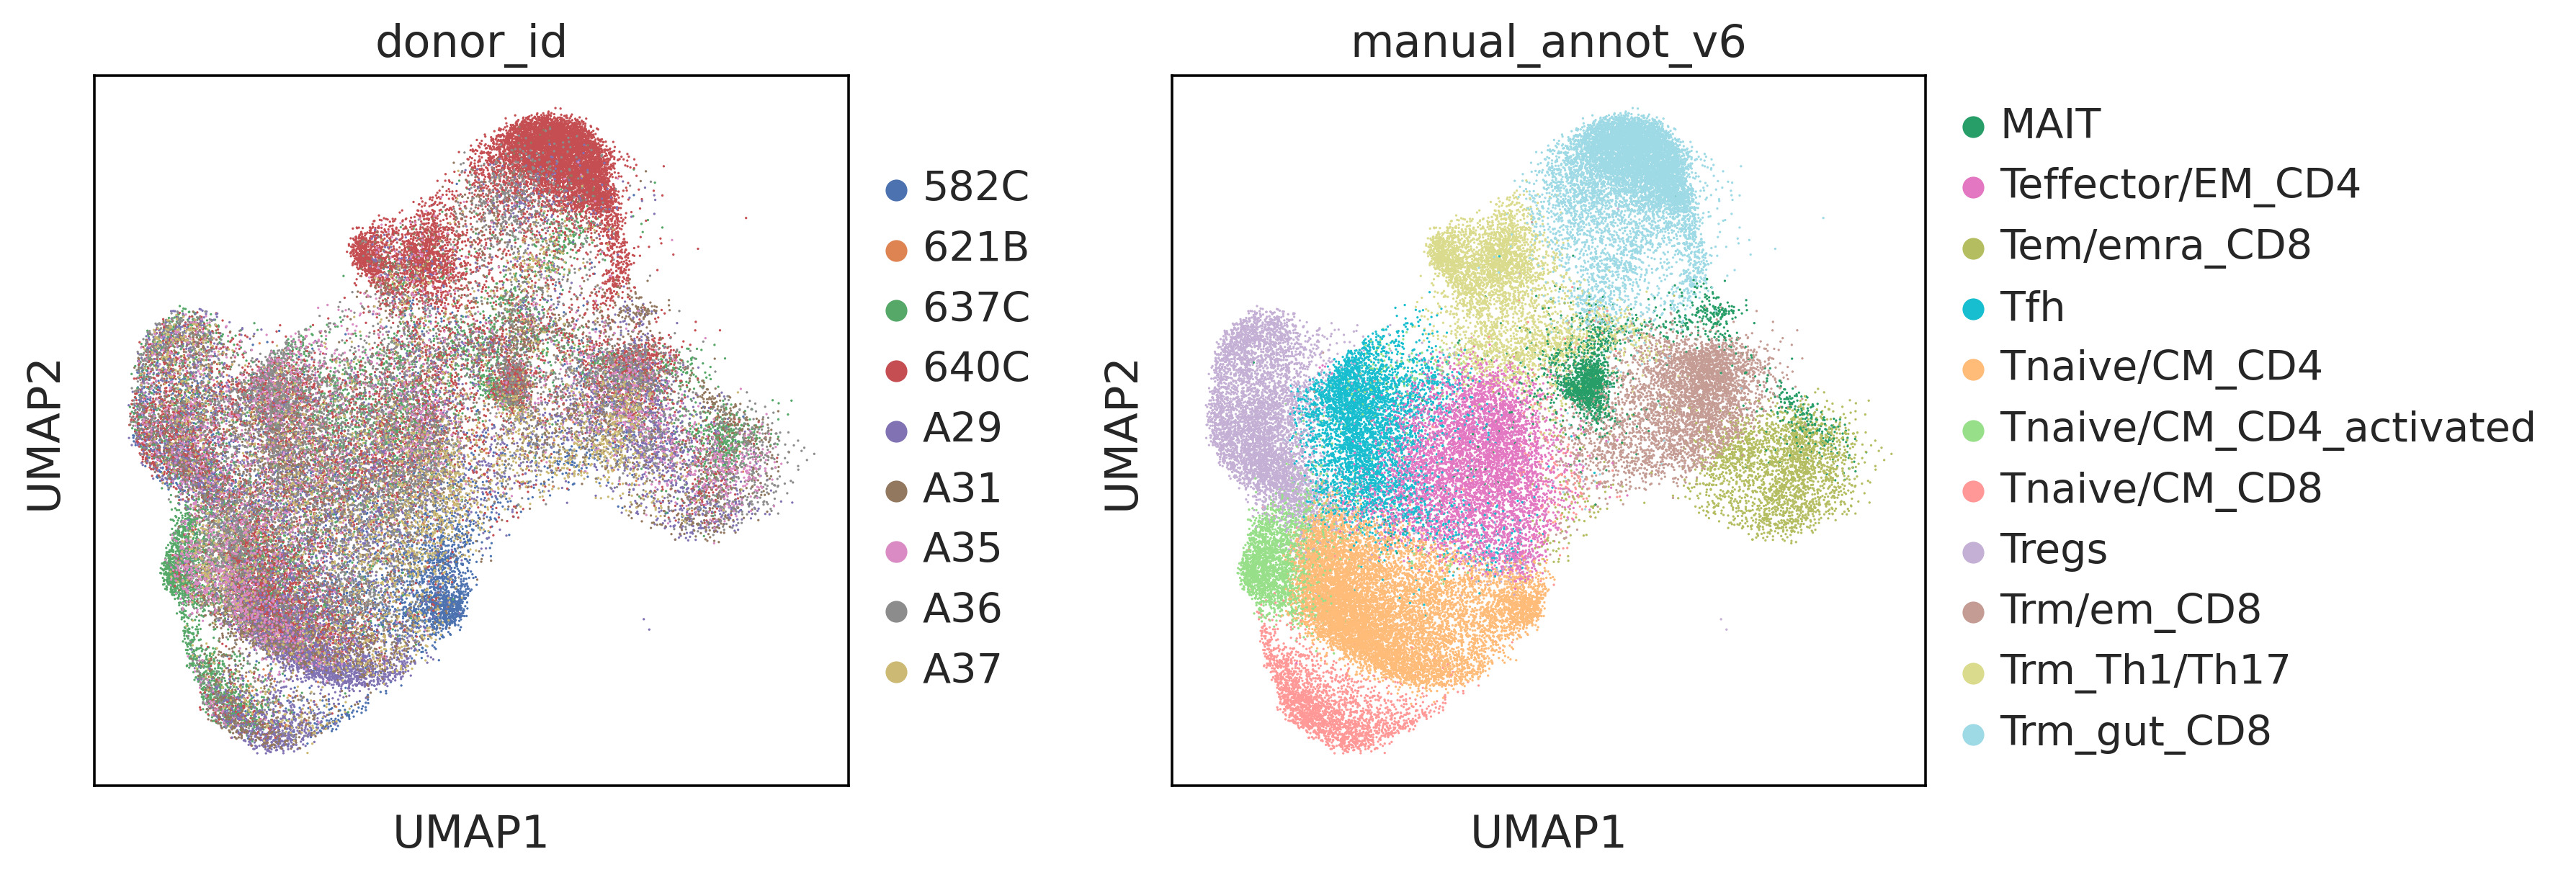

In [40]:
plt.rcParams["figure.figsize"] = [4,4]
sc.pl.umap(bdata, color=['donor_id','manual_annot_v6'], wspace=0.3,save='panimmune_cell_metadata.pdf')

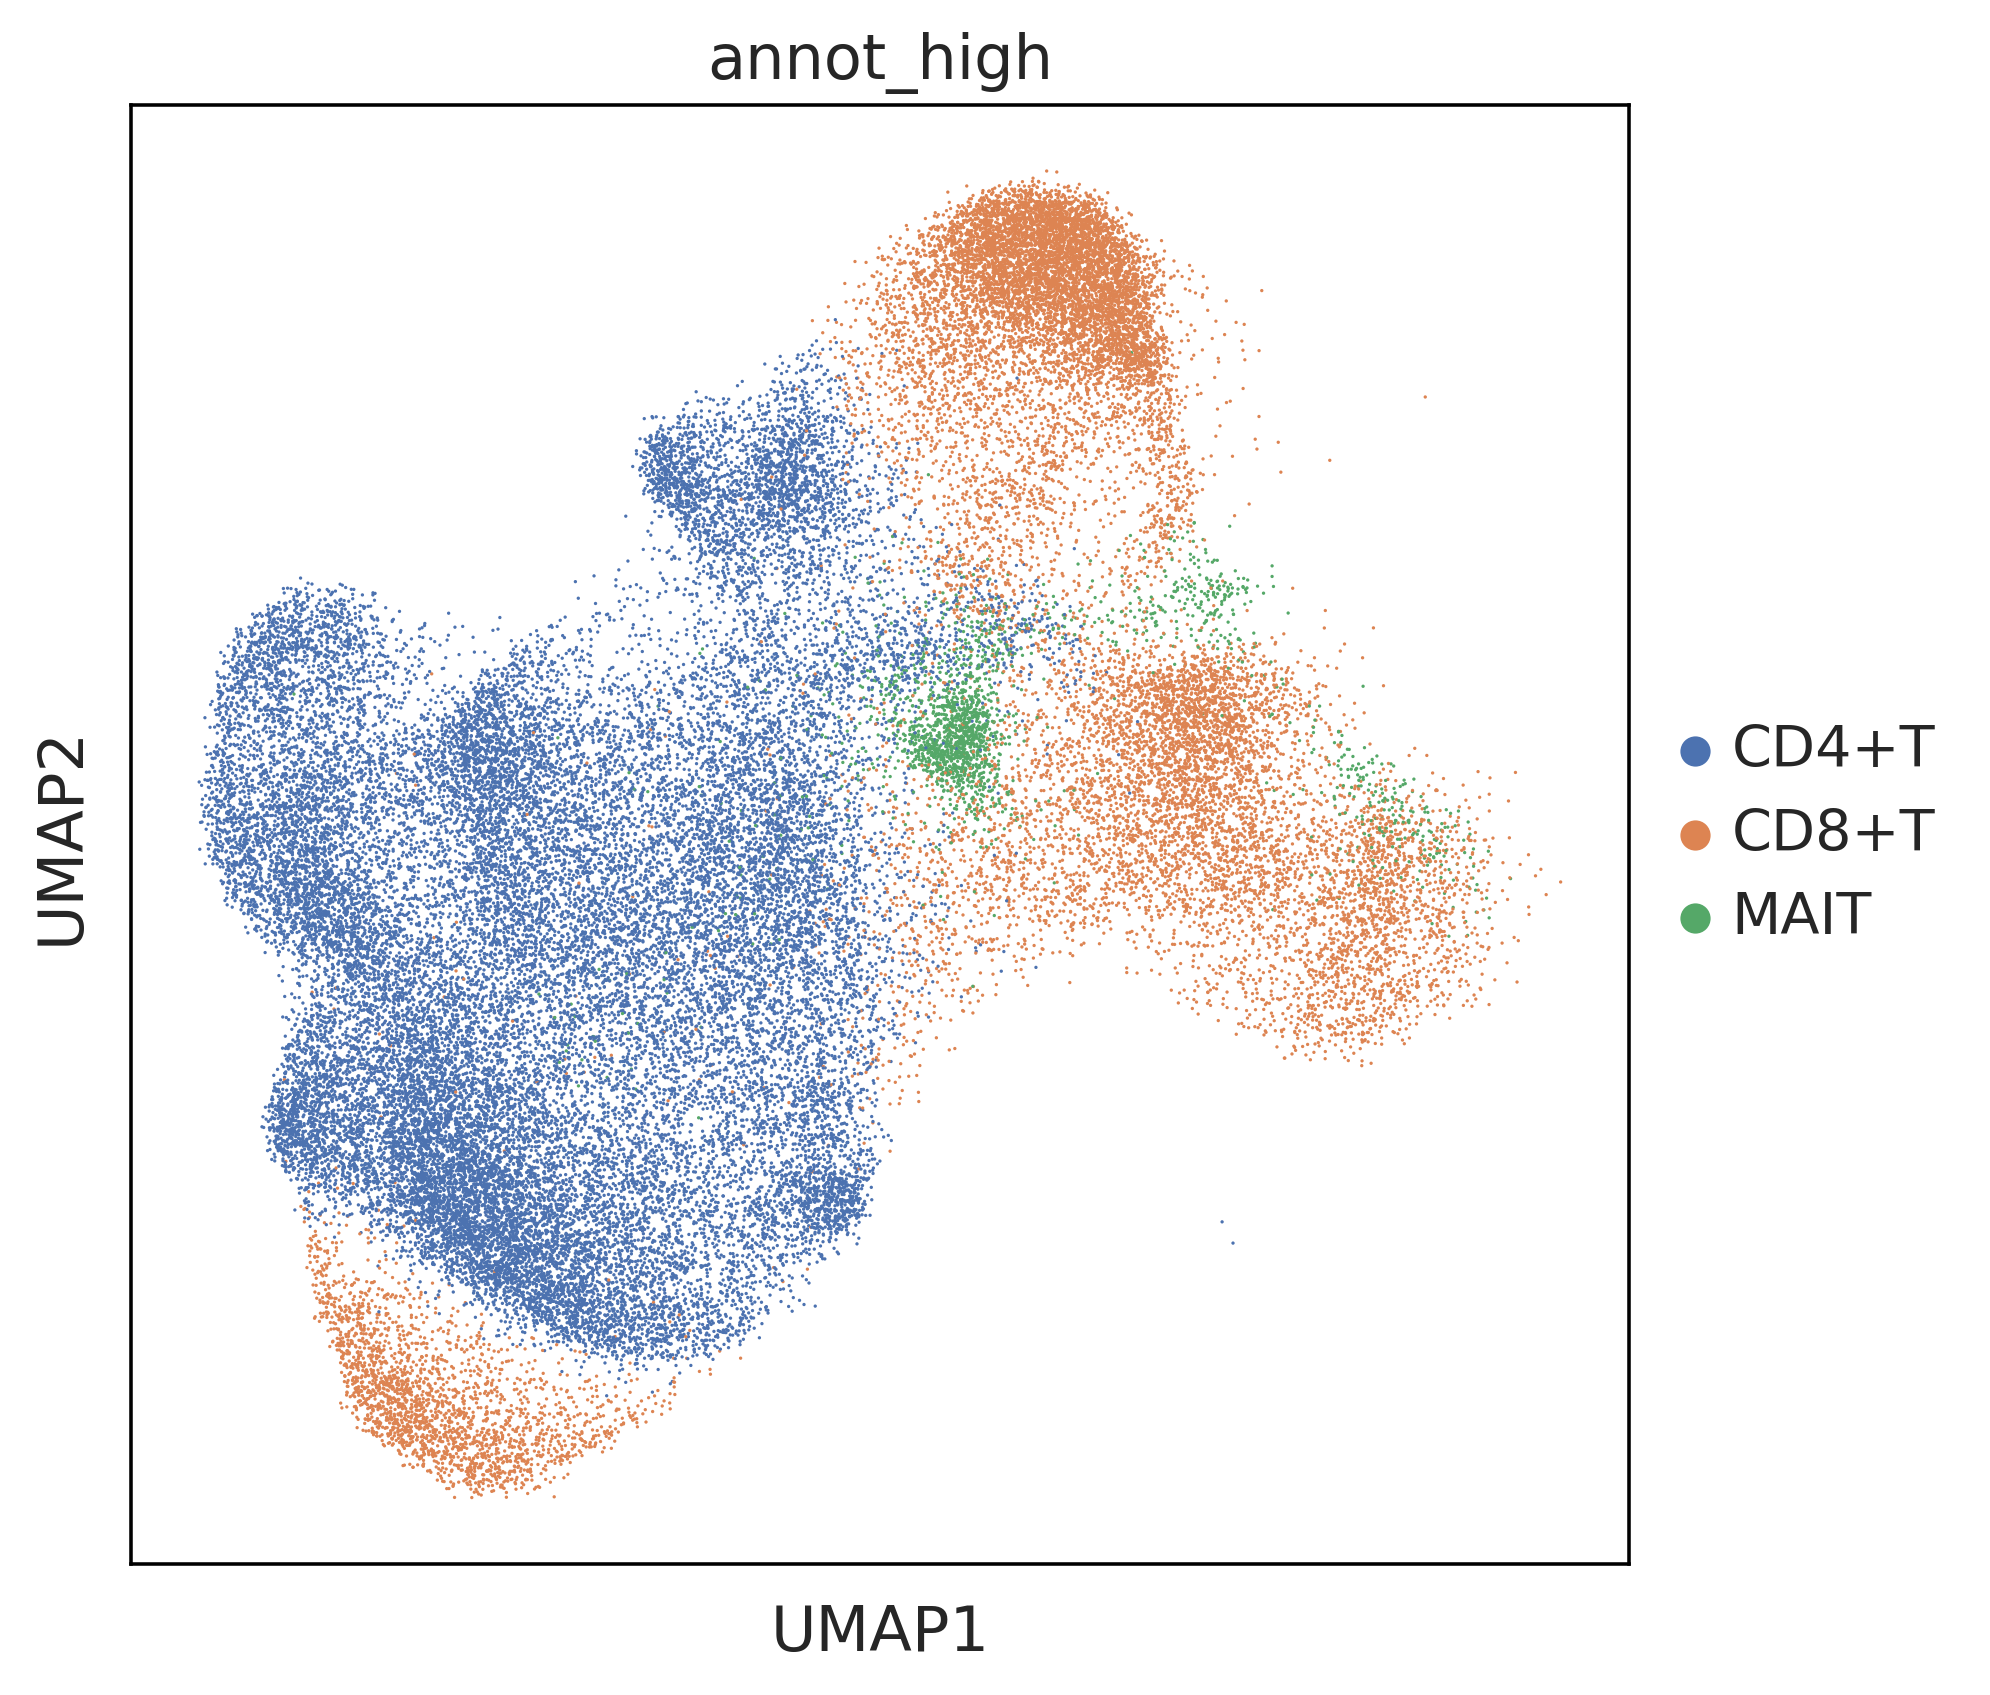

In [18]:
plt.rcParams["figure.figsize"] = [6,6]
sc.pl.umap(bdata, color=['annot_high'], save='panimmune_cell_annot_high.pdf')

In [28]:
bdata.write('write/panimmune_bdata.h5ad')

In [8]:
bdata = sc.read('write/panimmune_bdata.h5ad')

# Create pseudobulk VDJ feature space

In [21]:
bulk_adata = ddl.tl.vdj_pseudobulk(adata = bdata, obs_to_bulk = ['donor_id','manual_annot_v6'], obs_to_take = ['donor_id','manual_annot_v6','annot_high'],
                                   cols = ['IR_VDJ_1_v_gene', 'IR_VDJ_1_j_gene', 'IR_VJ_1_v_gene', 'IR_VJ_1_j_gene'])

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/dandelion/tools/_trajectory.py:302: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


     bulk_adata is the new pseudobulk VDJ feature space, whereby each observation is a cell neighbourhood
     VDJ usage frequency stored in bulk_adata.X
     VDJ genes stored in bulk_adata.var
     pseudobulk metadata stored in bulk_adata.obs
     can visualise the data using PCA or UMAP (see below)

In [23]:
# remove pseudobulks that have < 10 cells
bulk_adata = bulk_adata[bulk_adata.obs['cell_count']>=10]

In [32]:
# give higher annotation of CD4 vs CD8
bulk_adata.obs['annot_high'] = bulk_adata.obs['manual_annot_v6'].astype('str')
bulk_adata.obs.loc[bulk_adata.obs['manual_annot_v6'].isin(['Tem/emra_CD8','Tnaive/CM_CD8','Trm/em_CD8','Trm_gut_CD8']),'annot_high'] = 'CD8+T'
bulk_adata.obs.loc[bulk_adata.obs['manual_annot_v6'].isin(['Teffector/EM_CD4','Tfh','Tnaive/CM_CD4','Tnaive/CM_CD4_activated','Tregs','Trm_Th1/Th17']),'annot_high'] = 'CD4+T'

<ipython-input-32-ef3ac95e4996>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


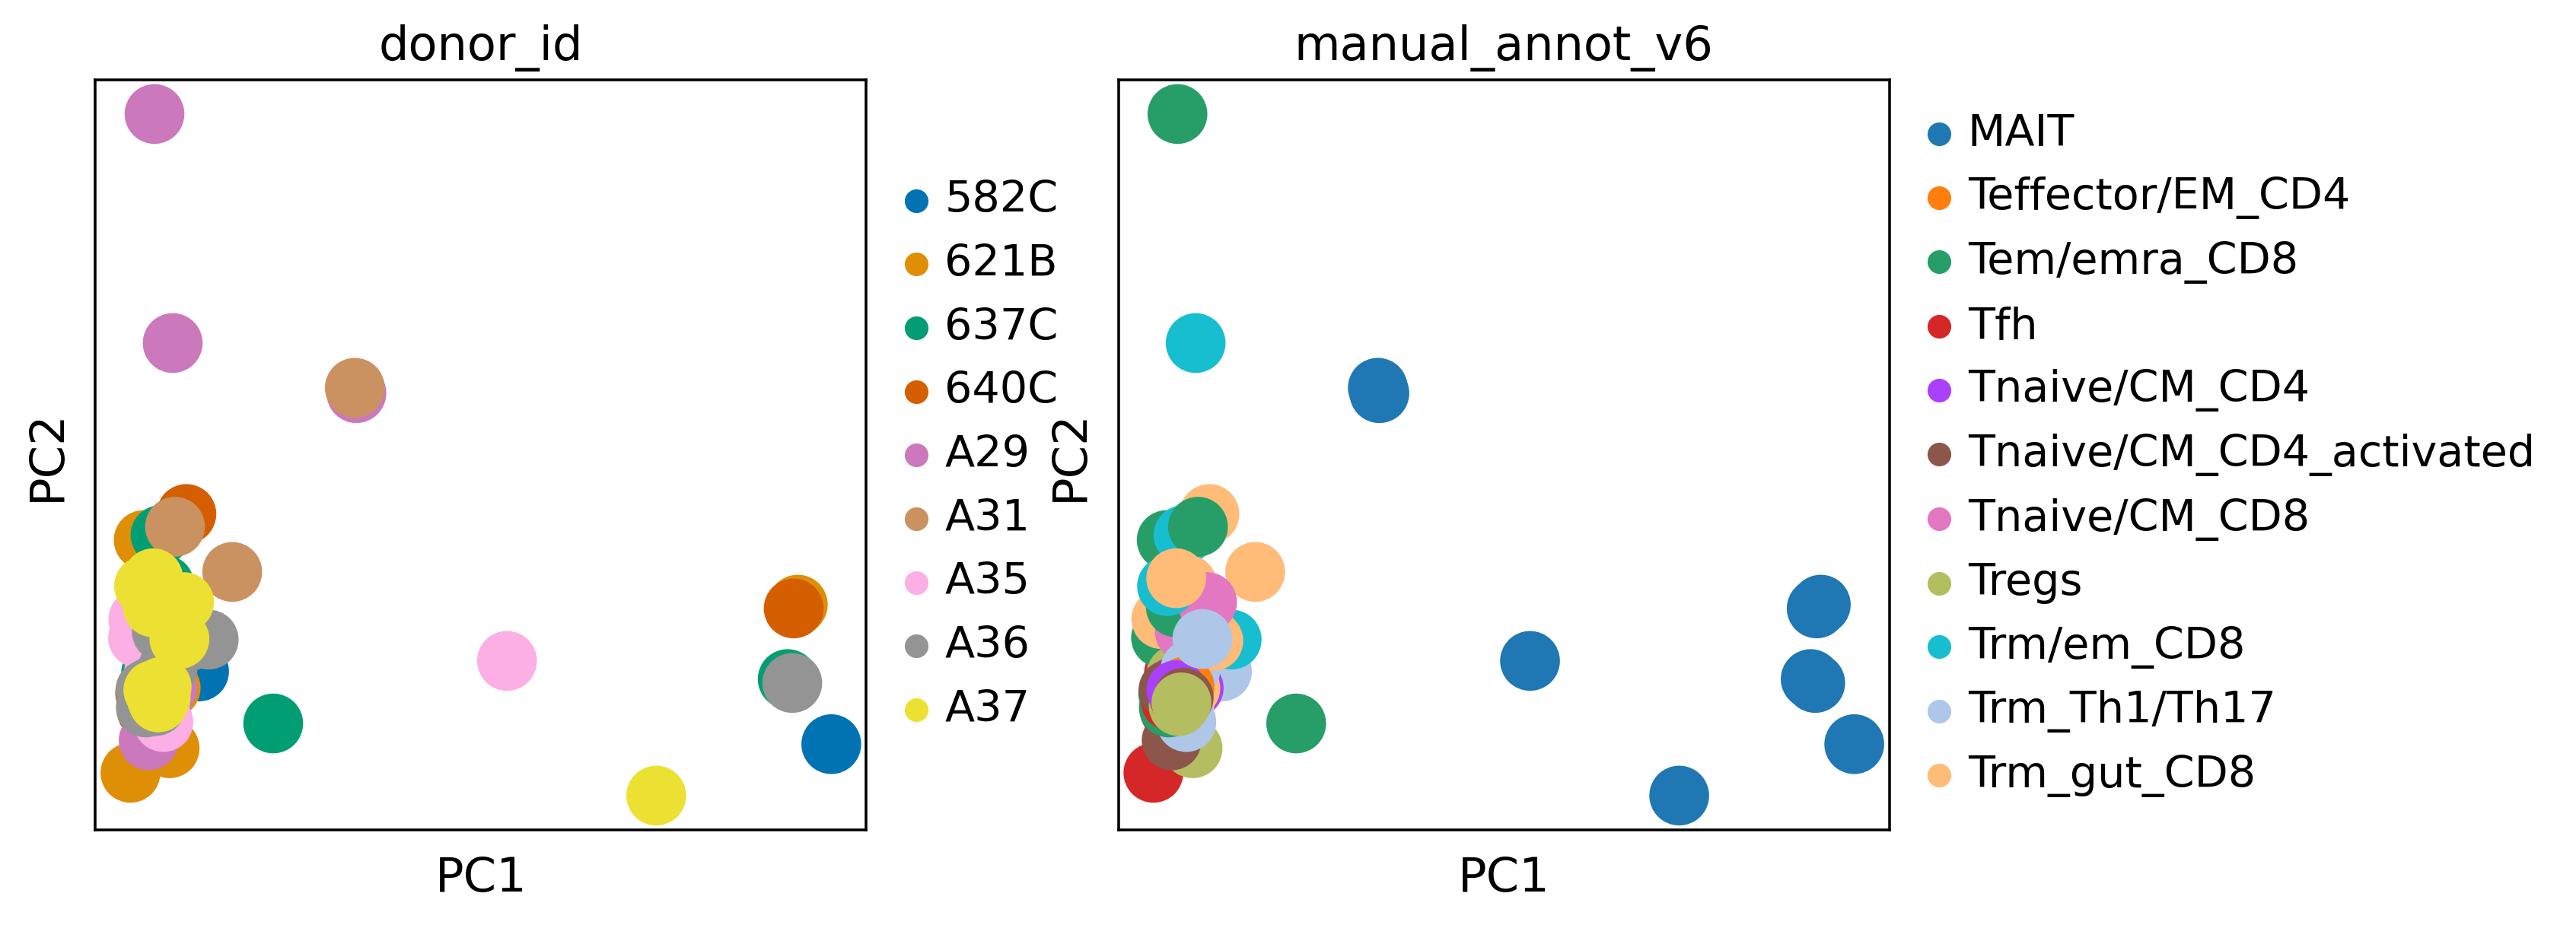

In [46]:
# remove pseudobulks with bulk_size < 30
#bulk_adata = bulk_adata[bulk_adata.obs['bulk_size']>=30]
sc.pp.pca(bulk_adata, random_state = 1712)
sc.pl.pca(bulk_adata, color=['donor_id','manual_annot_v6'])

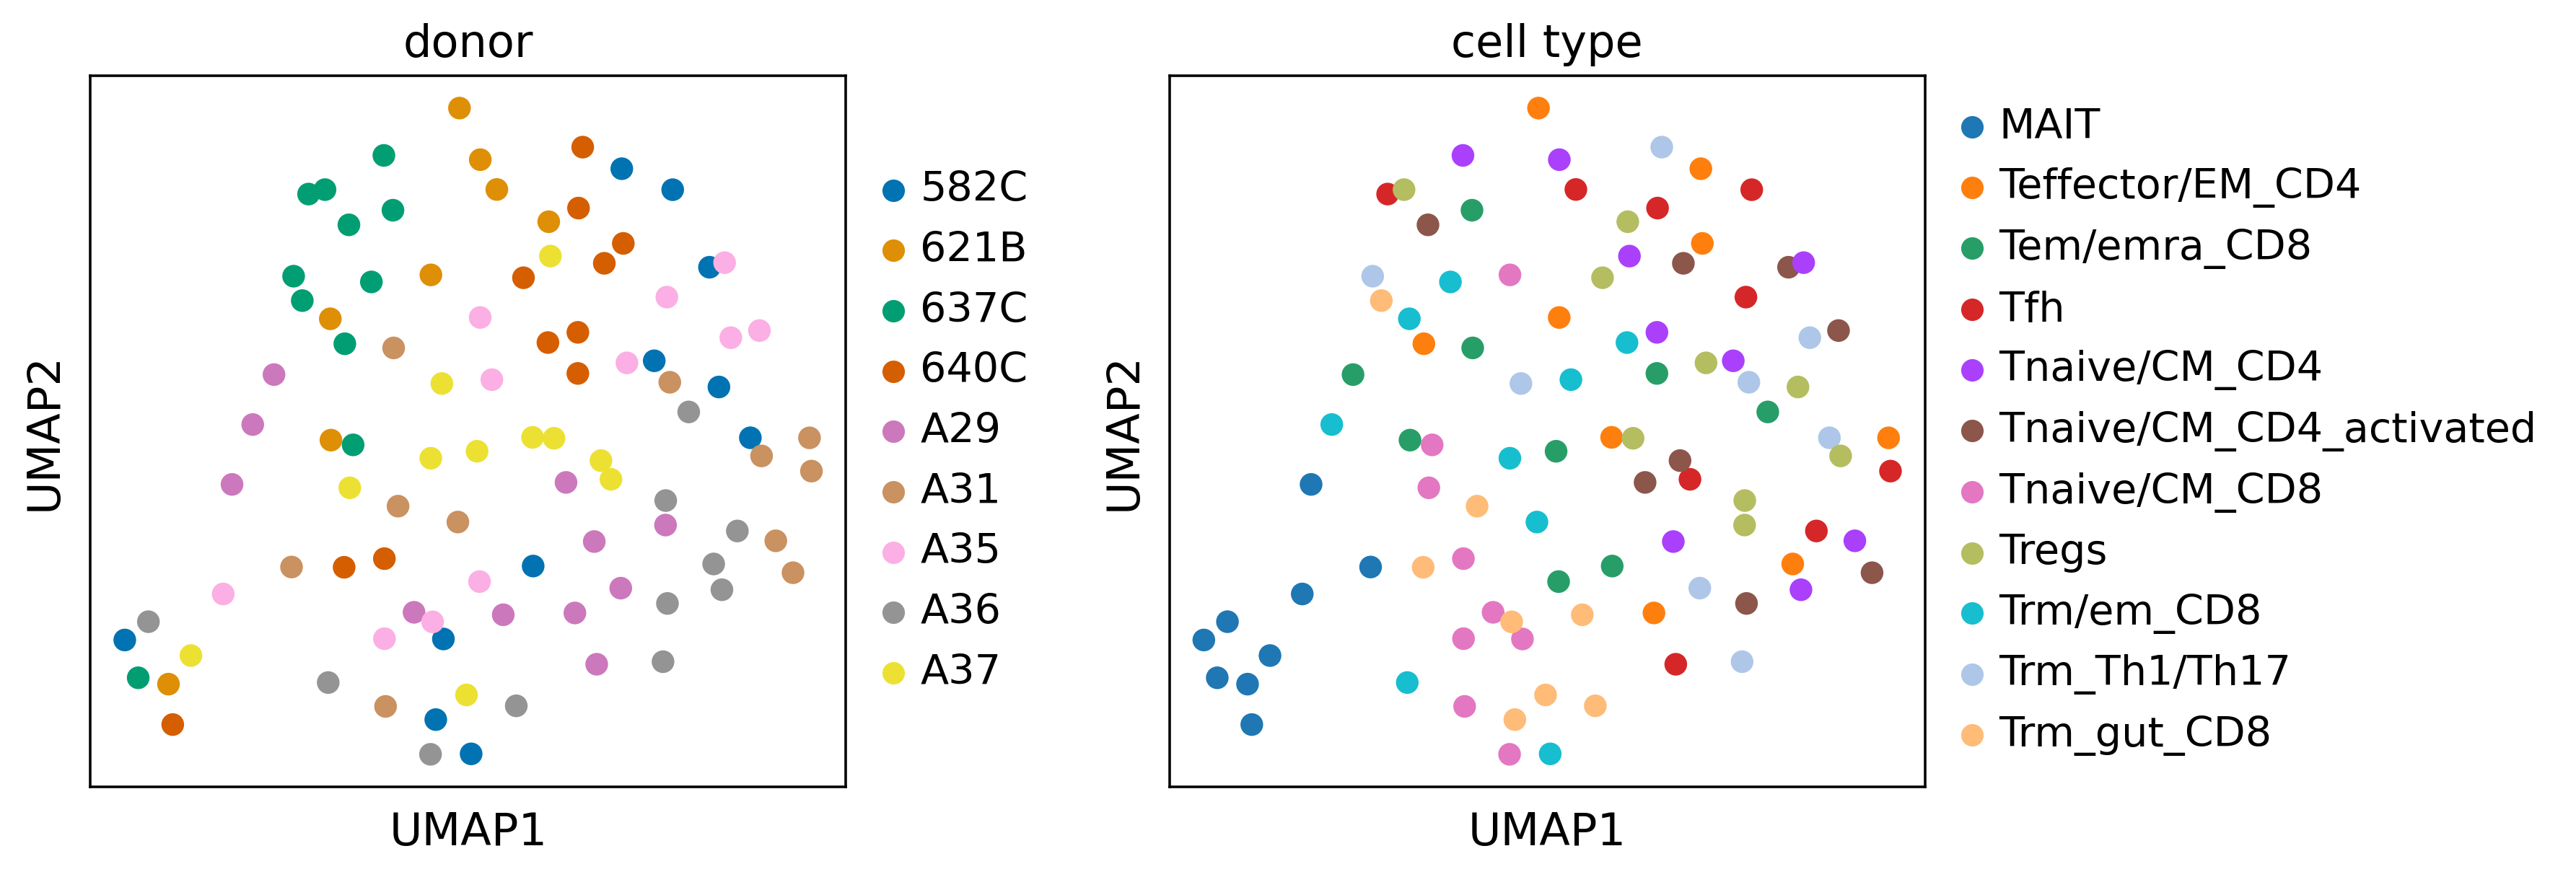

In [47]:
plt.rcParams["figure.figsize"] = [4,4]
sc.pp.neighbors(bulk_adata, random_state = 1712)
sc.tl.umap(bulk_adata, random_state = 1712)
sc.pl.umap(bulk_adata,  color=['donor_id','manual_annot_v6'],title=['donor','cell type'],ncols=2, 
           hspace=0.1, wspace=0.3,size=200,save='panimmune_pseudobulk.pdf')

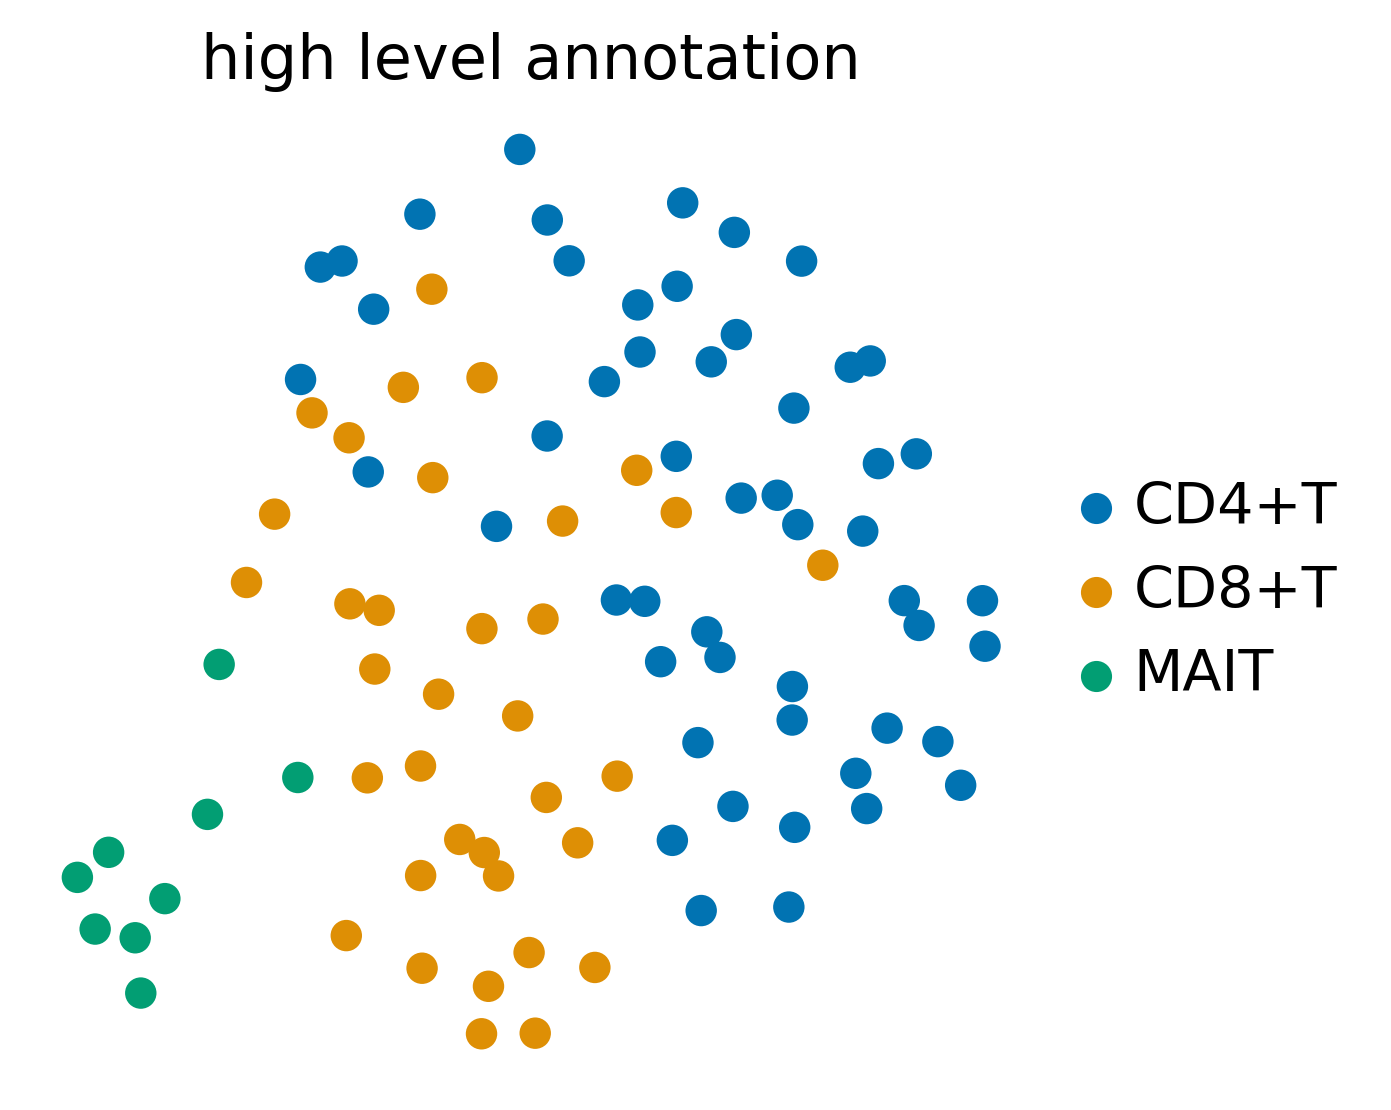

In [48]:
sc.pl.umap(bulk_adata,  color=['annot_high'],title=['high level annotation'],ncols=1, 
           hspace=0.1, wspace=0.1,frameon=False, size=200,save='panimmune_pseudobulk_annot_high.pdf')

### differential gene usage - wilcoxon test on pseudobulks directly i.e. all pseudobulks are of the same weighting

In [49]:
sc.tl.rank_genes_groups(bulk_adata, 'annot_high', method='wilcoxon')

In [50]:
result =bulk_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcox_clusters = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']})
wilcox_clusters.head(30)

CD4+T_n   CD4+T_l       CD4+T_p     CD8+T_n   CD8+T_l       CD8+T_p  \
0      TRAV9-2  1.580379  1.654087e-09      TRBV27  1.374518  4.851560e-07   
1        TRAV2  1.563020  5.273986e-09  TRAV14/DV4  1.322798  8.175654e-06   
2     TRAV26-1  1.065000  1.726280e-08      TRAV19  1.350171  1.041614e-05   
3      TRBV5-1  0.877222  9.443521e-08     TRBV4-1  1.836589  1.041614e-05   
4       TRAJ37  0.754852  1.649278e-07    TRAV12-2  1.054584  1.659345e-03   
5       TRAJ54  1.161558  2.178657e-07      TRBV13  1.906582  1.886039e-03   
6      TRBV7-2  1.178320  2.530608e-07      TRAJ26  0.784403  1.257386e-02   
7       TRBV18  1.091580  2.867274e-07     TRBJ2-7  0.472109  1.610125e-02   
8      TRBJ1-4  0.954900  7.031285e-07       TRAV5  1.111042  2.857568e-02   
9      TRAV8-4  0.966618  8.459456e-07      TRAJ28  0.750397  4.418987e-02   
10    TRBV10-3  1.192477  9.842734e-07     TRBV7-8  1.100276  5.620391e-02   
11      TRAJ44  0.946486  2.327369e-06     TRBJ2-1  0.255354  5.684707e-02   
12  TRAV36/DV7  1.418757  2.327369e-06     TRAV1-2 -1.560377  5.929681e-02   
13       TRBV2  0.701350  3.031017e-06      TRAJ30  0.698614  7.806076e-02   
14     TRBJ2-5  0.524633  3.031017e-06      TRAJ43  0.828089  7.806076e-02   
15      TRAJ56  1.399275  3.532458e-06      TRAJ45  0.860344  9.750659e-02   
16      TRBV30  1.124575  5.707080e-06     TRBV7-9  0.607476  1.118351e-01   
17     TRBJ1-6  0.785388  6.057823e-06      TRAJ34  0.968481  1.748686e-01   
18      TRAJ52  0.932770  7.631425e-06       TRBV9  0.789267  2.144811e-01   
19      TRAJ22  1.019265  9.971973e-06    TRBV29-1  0.318891  2.779340e-01   
20  TRAV23/DV6  1.700116  1.374315e-05     TRAV1-1  0.769301  2.897022e-01   
21      TRAJ48  0.756253  2.218430e-05      TRAJ24  0.626225  5.308393e-01   
22      TRAJ32  0.762163  4.125717e-05      TRAJ50  1.597948  6.236740e-01   
23      TRAJ23  1.056328  4.125717e-05      TRAV24  0.460490  6.403756e-01   
24      TRAV16  0.149411  5.389164e-05      TRAJ35  0.596537  6.403756e-01   
25     TRAV8-6  0.852665  5.389164e-05      TRAV27  0.947184  6.930116e-01   
26      TRAJ57  0.481216  8.768238e-05    TRBV10-2  0.719126  7.033513e-01   
27      TRAJ17  1.008529  9.987098e-05      TRAJ20  0.188769  7.074411e-01   
28    TRAV13-2  0.895612  9.987098e-05      TRAV21  0.200324  7.082289e-01   
29    TRBV12-3  0.515071  1.682769e-04      TRAV18  4.611131  7.304244e-01   

      MAIT_n     MAIT_l    MAIT_p  
0    TRAV1-2   5.115430  0.000138  
1     TRAJ33   4.555597  0.000232  
2    TRBV6-4   4.773900  0.000704  
3    TRBJ2-6   2.399198  0.004520  
4   TRBV20-1   1.031275  0.016420  
5    TRBV6-1   1.380755  0.038752  
6    TRBV6-2   1.316171  0.060595  
7    TRBJ2-3   0.517930  0.167657  
8     TRAJ12   2.698723  0.255614  
9    TRBJ2-2   0.668010  0.298168  
10   TRBV4-2   2.347226  0.400952  
11   TRBJ2-1   0.397480  0.421481  
12  TRBV25-1   2.592383  0.644687  
13    TRBV15   0.620434  0.698374  
14  TRBV10-1   1.674786  0.698501  
15    TRAV10   0.695192  0.703546  
16     TRAV7   1.122787  0.763256  
17   TRBV6-5   1.124901  0.768178  
18   TRBV6-9   3.320860  0.837789  
19   TRBV4-3   1.498232  0.841677  
20    TRAJ18   0.638841  0.841677  
21   TRBV5-7 -13.164555  0.954893  
22   TRAV9-1 -16.056709  0.915653  
23    TRAJ61 -14.597200  0.915653  
24    TRAV18 -17.814531  0.841677  
25   TRBV7-4 -16.512283  0.812880  
26    TRAJ25 -18.056414  0.812880  
27   TRBV6-8 -15.970208  0.778090  
28   TRBV6-7 -17.565655  0.748266  
29    TRAV25  -0.007696  0.611222

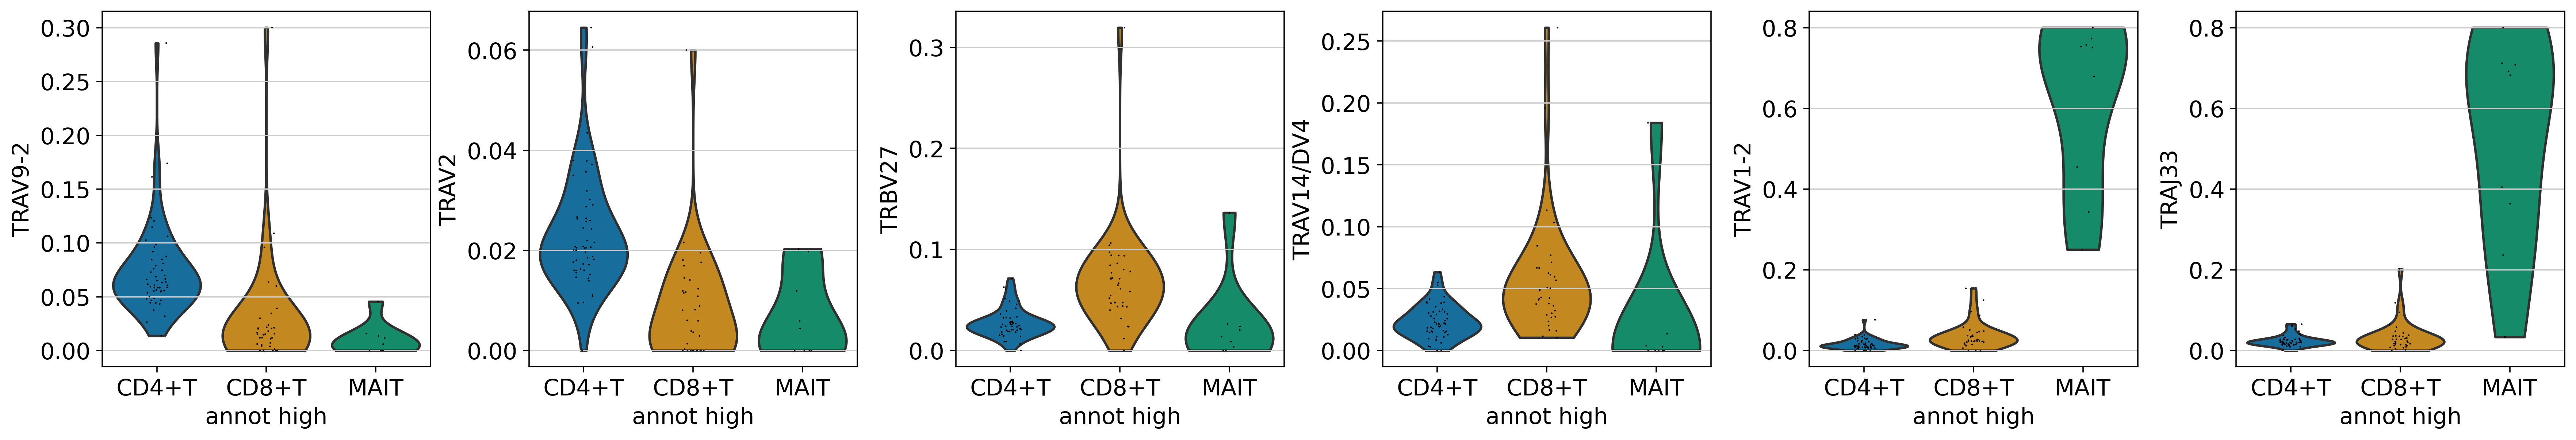

In [51]:
genes = list(wilcox_clusters['CD4+T_n'][0:2]) + list(wilcox_clusters['CD8+T_n'][0:2])+list(wilcox_clusters['MAIT_n'][0:2])
sc.pl.violin(bulk_adata, keys=genes, groupby='annot_high',save='panimmune_genes.pdf')

In [52]:
wilcox_clusters.to_csv('~/mount/gdrive/VDJ_collab/manuscript/supplement/panimmune_differential_VDJ.csv')